In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.utils import Bunch

# Importing locally here, but the prox bias and efaar_benchmarking packages are available through Nexus
module_path = os.path.abspath(os.path.join("../../../proxbias"))
if module_path not in sys.path:
    sys.path.insert(0, module_path)
module_path = os.path.abspath(os.path.join("../../../EFAAR_benchmarking"))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from proxbias import utils
from proxbias.utils.df_tools import harmonize_data, make_pairwise_cos, make_split_cosmat
from proxbias.utils.q_norm import q_norm
from proxbias.plotting.heatmaps import plot_heatmap
from proxbias.metrics import bm_metrics
from proxbias.plotting.bm_bars import plot_bm_arm_bars, plot_bm_bar_pairs

# This is necesary for the svg output plots to have editable text
plt.rcParams["svg.fonttype"] = "none"

# Just to make the notebook take up full screen real estate, not necessary
from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))

/mnt/ps/home/CORP/nathan.lazar/.pyenv/versions/tatooine/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Load in DepMap dependency data for 19q3, 22q4 and 23q2

Files were downloaded from [here](https://depmap.org/portal/download/all/) for 19Q3, 22Q4 and 23Q2 datasets and moved into the `data/depmap19q3`, `data/depmap22q4/` and `data/depmap23q2/` directories.

You can also use the `get_depmap_data` function in `proxbias.depmap.load` for 22Q4 and 23Q2, but 19Q3 has a different file name (`Achilles_gene_effect.csv` instead of `CRISPRGeneEffect.csv`) and the function doesn't handle that right now. 

In [2]:
files = {
    "19q3": "depmap19q3/Achilles_gene_effect.csv",
    "22q4": "depmap22q4/CRISPRGeneEffect.csv",
    "23q2": "depmap23q2/CRISPRGeneEffect.csv",
}

depmap_data = {}
depmap_cleaned = {}
for dataset in ["19q3", "22q4", "23q2"]:
    print(dataset)
    data_dir = "../data"
    dependency_data = pd.read_csv(os.path.join(data_dir, files[dataset]), index_col=0).T
    dependency_data.index = [g.split(" ")[0] for g in dependency_data.index]  # remove entrez gene ids
    dependency_data.index.name = "gene"
    print(dependency_data.shape)
    depmap_data[dataset] = dependency_data

    ## Cleanup: Drop genes that don't have dependency data for all cell lines.
    n_cl_missing = dependency_data.isna().sum(axis=1)
    print(f"{(n_cl_missing!=0).sum()} genes are missing dependency data, we drop them.")
    depmap_cleaned[dataset] = dependency_data.loc[n_cl_missing == 0, :]

19q3
(18333, 625)
734 genes are missing dependency data, we drop them.
22q4
(17453, 1078)
0 genes are missing dependency data, we drop them.
23q2
(17931, 1095)
729 genes are missing dependency data, we drop them.


## Distribution of dependency scores

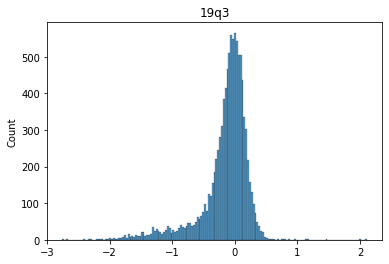

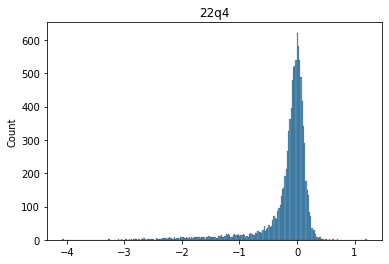

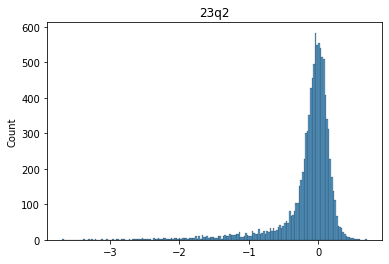

In [3]:
for dataset in ["19q3", "22q4", "23q2"]:
    plt.figure()
    plt.title(dataset)
    sns.histplot(np.random.choice(depmap_cleaned[dataset].values.flatten(), 10000));

### Center data

In [4]:
depmap_centered = {}
for dataset in ["19q3", "22q4", "23q2"]:
    depmap_centered[dataset] = depmap_cleaned[dataset].sub(depmap_cleaned[dataset].mean(axis=1), axis=0)

## Distribution of dependency scores after centering per gene.

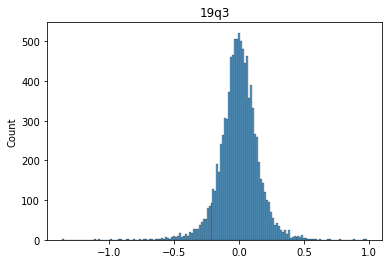

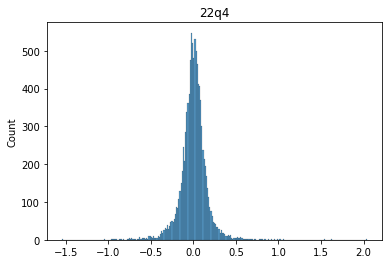

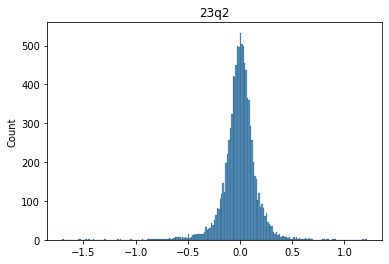

In [5]:
for dataset in ["19q3", "22q4", "23q2"]:
    plt.figure()
    plt.title(dataset)
    sns.histplot(np.random.choice(depmap_centered[dataset].values.flatten(), 10000));

# Add in chromosome positions
Drop genes without annotations

In [6]:
gene_dict, chrom_dict, band_dict = utils.chromosome_info.get_chromosome_info_as_dicts()
genes = list(gene_dict.keys())

depmap = {}
for dataset in ["19q3", "22q4", "23q2"]:
    print(dataset)

    # Subset to genes with chrom information from hg38
    idx = depmap_centered[dataset].query(f"gene.isin({genes})").index
    print(f"Full data has {depmap_centered[dataset].shape[0]} genes, {len(idx)} of which are in annotations")
    depmap[dataset] = depmap_centered[dataset].loc[idx]

    # Add in chromomsome information
    def _add_chr_info(df, gene_dict, in_nm, out_nm):
        df[out_nm] = (
            depmap[dataset].index.to_frame().gene.apply(lambda x: gene_dict[x][in_nm] if x in gene_dict else "no_info")
        )
        return df

    old_cols = depmap[dataset].columns.tolist()
    depmap[dataset] = _add_chr_info(depmap[dataset], gene_dict, "chrom", "chromosome")
    depmap[dataset] = _add_chr_info(depmap[dataset], gene_dict, "chrom_int", "chr_idx")
    depmap[dataset] = _add_chr_info(depmap[dataset], gene_dict, "arm", "chromosome_arm")
    depmap[dataset] = _add_chr_info(depmap[dataset], gene_dict, "start", "gene_bp")

    cols = ["gene", "chromosome", "chr_idx", "chromosome_arm", "gene_bp"]
    depmap[dataset] = depmap[dataset].reset_index().set_index(cols).sort_values(["chr_idx", "gene_bp"])

19q3
Full data has 17599 genes, 17192 of which are in annotations
22q4
Full data has 17453 genes, 17396 of which are in annotations
23q2
Full data has 17202 genes, 17147 of which are in annotations


In [7]:
for dataset in ["19q3", "22q4", "23q2"]:
    display(depmap[dataset].head(2))

ACH-000004  ACH-000005  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
OR4F5  chr1       1       chr1p          65418      0.068017    0.092175   
OR4F29 chr1       1       chr1p          450739     0.045194    0.152855   

                                                  ACH-000007  ACH-000009  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
OR4F5  chr1       1       chr1p          65418      0.204709   -0.067036   
OR4F29 chr1       1       chr1p          450739     0.094469   -0.019420   

                                                  ACH-000011  ACH-000012  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
OR4F5  chr1       1       chr1p          65418     -0.042096    0.044669   
OR4F29 chr1       1       chr1p          450739    -0.268919   -0.123328   

                                                  ACH-000013  ACH-000014  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
OR4F5  chr1       1       chr1p          65418      0.041300    0.117099   
OR4F29 chr1       1       chr1p          450739     0.056884    0.014744   

                                                  ACH-000015  ACH-000017  ...  \
gene   chromosome chr_idx chromosome_arm gene_bp                          ...   
OR4F5  chr1       1       chr1p          65418      0.074322   -0.009673  ...   
OR4F29 chr1       1       chr1p          450739     0.097887   -0.276503  ...   

                                                  ACH-001736  ACH-001737  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
OR4F5  chr1       1       chr1p          65418      0.074023    0.466297   
OR4F29 chr1       1       chr1p          450739    -0.164333   -0.049935   

                                                  ACH-001740  ACH-001745  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
OR4F5  chr1       1       chr1p          65418     -0.144796   -0.012623   
OR4F29 chr1       1       chr1p          450739    -0.251974    0.014691   

                                                  ACH-001750  ACH-001765  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
OR4F5  chr1       1       chr1p          65418     -0.066856    0.044151   
OR4F29 chr1       1       chr1p          450739    -0.101502    0.138910   

                                                  ACH-001814  ACH-001838  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
OR4F5  chr1       1       chr1p          65418      0.100245   -0.118192   
OR4F29 chr1       1       chr1p          450739    -0.371399    0.023600   

                                                  ACH-001956  ACH-001957  
gene   chromosome chr_idx chromosome_arm gene_bp                          
OR4F5  chr1       1       chr1p          65418     -0.174867    0.008171  
OR4F29 chr1       1       chr1p          450739    -0.015659   -0.012484  

[2 rows x 625 columns]

ACH-000004  ACH-000005  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.138971   -0.024604   
NOC2L  chr1       1       chr1p          944202    -0.337622    0.298930   

                                                  ACH-000007  ACH-000009  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.164436   -0.135659   
NOC2L  chr1       1       chr1p          944202    -0.277252   -0.199345   

                                                  ACH-000011  ACH-000012  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.181989   -0.007635   
NOC2L  chr1       1       chr1p          944202     0.045464   -0.445447   

                                                  ACH-000013  ACH-000014  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.050045   -0.001966   
NOC2L  chr1       1       chr1p          944202     0.153700   -0.053124   

                                                  ACH-000015  ACH-000017  ...  \
gene   chromosome chr_idx chromosome_arm gene_bp                          ...   
SAMD11 chr1       1       chr1p          923922      0.05847   -0.058567  ...   
NOC2L  chr1       1       chr1p          944202      0.14612   -0.107405  ...   

                                                  ACH-002283  ACH-002284  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.132243   -0.130717   
NOC2L  chr1       1       chr1p          944202    -0.033149   -0.023406   

                                                  ACH-002285  ACH-002294  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922    -0.148272    0.133393   
NOC2L  chr1       1       chr1p          944202    -0.285678    0.009905   

                                                  ACH-002295  ACH-002296  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922    -0.030585    0.042350   
NOC2L  chr1       1       chr1p          944202    -0.110960   -0.309166   

                                                  ACH-002297  ACH-002298  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.046475    0.086503   
NOC2L  chr1       1       chr1p          944202    -0.058206   -0.188165   

                                                  ACH-002304  ACH-002305  
gene   chromosome chr_idx chromosome_arm gene_bp                          
SAMD11 chr1       1       chr1p          923922     -0.05088    0.187428  
NOC2L  chr1       1       chr1p          944202     -0.59778    0.065761  

[2 rows x 1078 columns]

ModelID                                           ACH-000001  ACH-000004  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.047577     0.10238   
NOC2L  chr1       1       chr1p          944202     0.484032    -0.24410   

ModelID                                           ACH-000005  ACH-000007  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922    -0.076463    0.186915   
NOC2L  chr1       1       chr1p          944202     0.280216   -0.387235   

ModelID                                           ACH-000009  ACH-000011  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922    -0.158954     0.15448   
NOC2L  chr1       1       chr1p          944202    -0.119934    -0.04632   

ModelID                                           ACH-000012  ACH-000013  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.005407    0.098182   
NOC2L  chr1       1       chr1p          944202    -0.375034    0.129755   

ModelID                                           ACH-000014  ACH-000015  ...  \
gene   chromosome chr_idx chromosome_arm gene_bp                          ...   
SAMD11 chr1       1       chr1p          923922    -0.001502    0.075654  ...   
NOC2L  chr1       1       chr1p          944202    -0.032229    0.072199  ...   

ModelID                                           ACH-002687  ACH-002693  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922    -0.032343    0.116028   
NOC2L  chr1       1       chr1p          944202     0.195969    0.111704   

ModelID                                           ACH-002710  ACH-002785  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922      0.07740    0.083375   
NOC2L  chr1       1       chr1p          944202     -0.09102   -0.115503   

ModelID                                           ACH-002799  ACH-002800  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922    -0.032725    0.117811   
NOC2L  chr1       1       chr1p          944202     0.149794   -0.209500   

ModelID                                           ACH-002834  ACH-002847  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.091653    0.095124   
NOC2L  chr1       1       chr1p          944202     0.130630   -0.202242   

ModelID                                           ACH-002922  ACH-002926  
gene   chromosome chr_idx chromosome_arm gene_bp                          
SAMD11 chr1       1       chr1p          923922     0.094808    0.018674  
NOC2L  chr1       1       chr1p          944202    -0.005151   -0.016676  

[2 rows x 1095 columns]

# Make a split heatmap with the 19Q3 and 22Q4 data

Steps:
- Harmonize before pairwise (after cleaning). This drops genes not present in both datasets.
- Make pairwise matrices for each dataset
- Quantile normalize each dataset
- Make split matrix
- Plot

In [21]:
# Harmonize data
depmap2 = {}
intersect_genes = np.intersect1d(
    depmap["19q3"].index.get_level_values("gene"), depmap["22q4"].index.get_level_values("gene")
)
depmap2["19q3"] = depmap["19q3"].query("gene in @intersect_genes")
depmap2["22q4"] = depmap["22q4"].query("gene in @intersect_genes")

In [22]:
# This step can be slow - takes a ~14 minutes on my machine
depmap_mat = {}
depmap_mat_norm = {}
for dataset in ["19q3", "22q4"]:
    depmap_mat[dataset] = make_pairwise_cos(depmap2[dataset])
    depmap_mat_norm[dataset] = q_norm(depmap_mat[dataset])

## Plot full genome split heatmap - 19Q3 above diagonal, 22Q4 below

In [23]:
path = "plots"
if not os.path.exists(path):
    os.mkdir(path)

In [24]:
depmap_19q3_22q4_split = make_split_cosmat(depmap_mat_norm["19q3"], depmap_mat_norm["22q4"])

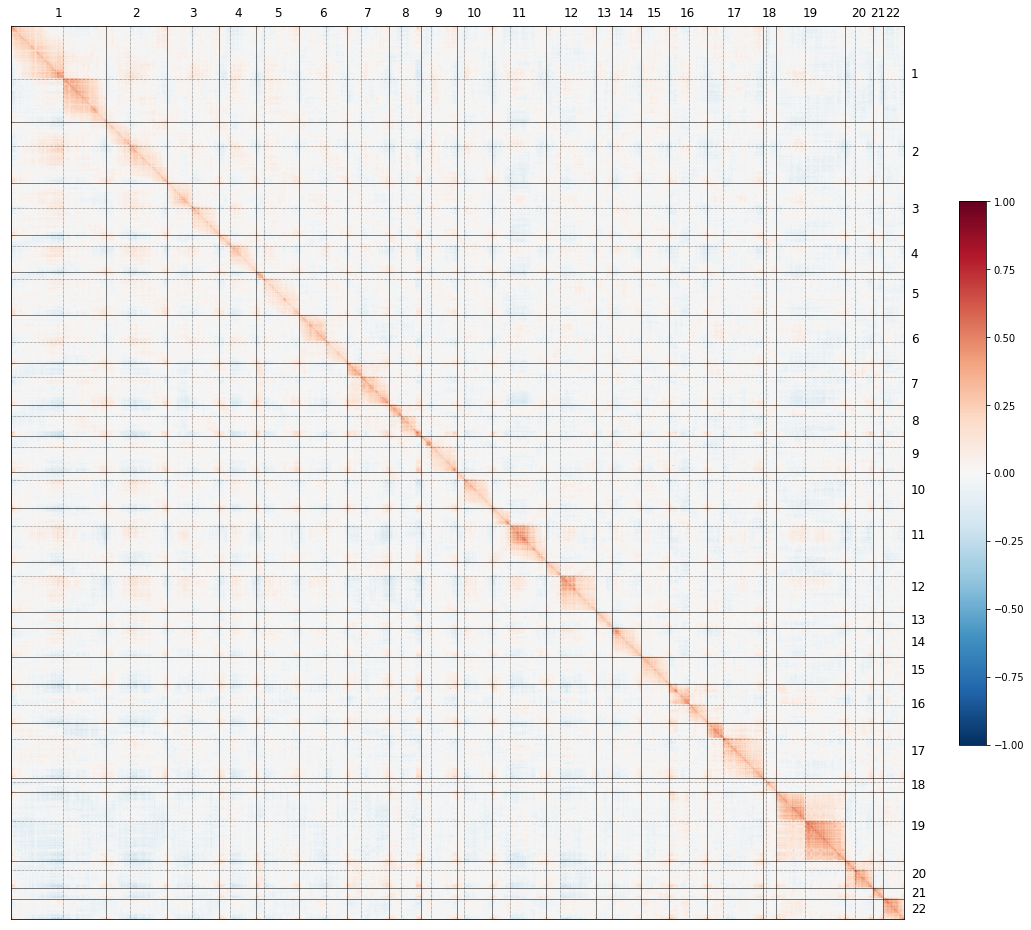

In [25]:
plot_heatmap(
    depmap_19q3_22q4_split,
    f_name=os.path.join(path, "depmap_19q3_vs_22q4_split.svg"),
    format="svg",
    show_chr_lines=True,
    show_cent_lines=True,
    crunch_factor=10,
    title="",
)

## Zoom of chrom 1
These two datasets are very similar, but not identical

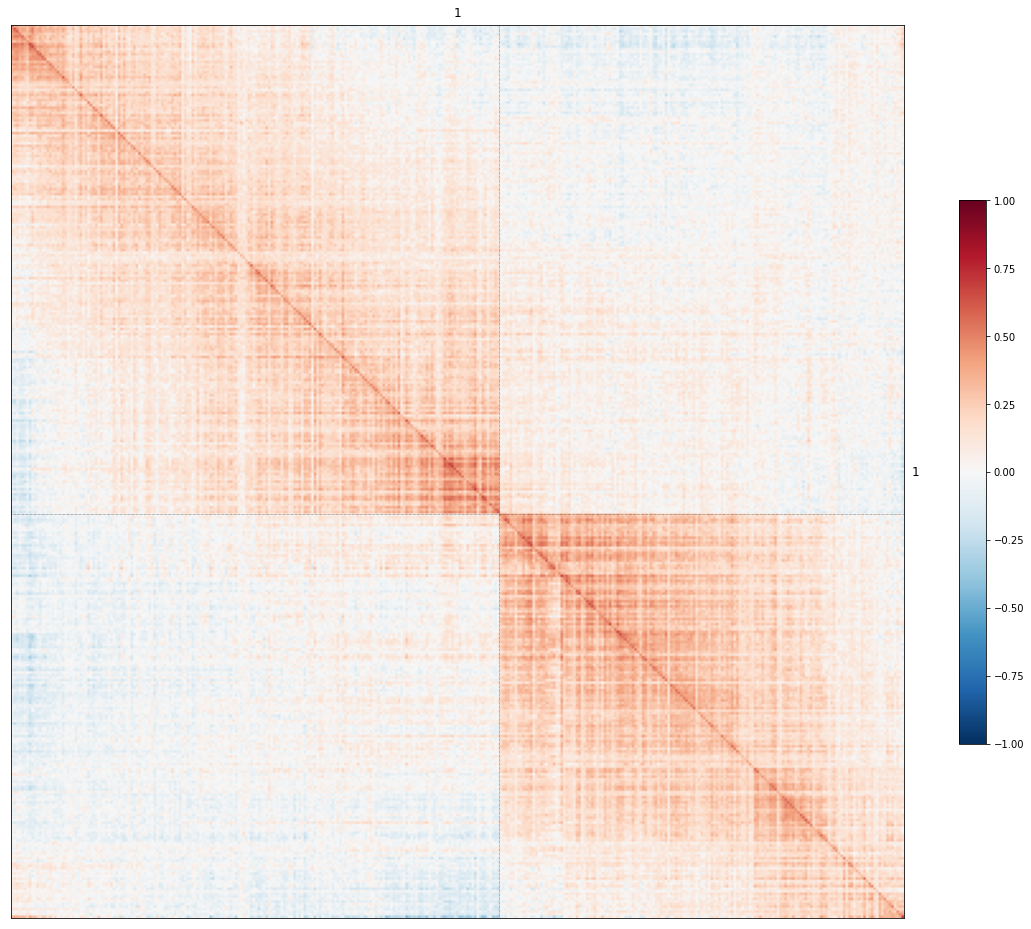

In [26]:
idx = depmap_19q3_22q4_split.query('chromosome=="chr1"').index
plot_heatmap(
    depmap_19q3_22q4_split.loc[idx, idx],
    f_name=os.path.join(path, "depmap_19q3_vs_22q4_split_chr1.svg"),
    format="svg",
    show_chr_lines=True,
    show_cent_lines=True,
    crunch_factor=5,
    title="",
)

In [27]:
# Setting sample fraction helps avoid memory issues
bm_all = {}
bm_arm = {}
for dataset in ["19q3", "22q4"]:
    bm_all[dataset], bm_arm[dataset] = bm_metrics(depmap_mat_norm[dataset], verbose=False, sample_frac=0.1)

In [92]:
tmp1 = bm_arm["19q3"].copy()
tmp1.index.name = "Chromosome arm"
tmp1 = tmp1.assign(Condition="19q3")
tmp1 = tmp1.reset_index().set_index(["Condition", "Chromosome arm"])

tmp2 = bm_arm["22q4"].copy()
tmp2.index.name = "Chromosome arm"
tmp2 = tmp2.assign(Condition="22q4")
tmp2 = tmp2.reset_index().set_index(["Condition", "Chromosome arm"])

arm_stats_df = pd.concat([tmp1, tmp2])

In [53]:
del plot_bm_bar_pairs
# from proxbias.plotting.bm_bars import plot_bm_bar_pairs
import matplotlib as mpl
import matplotlib.patches as mpatches

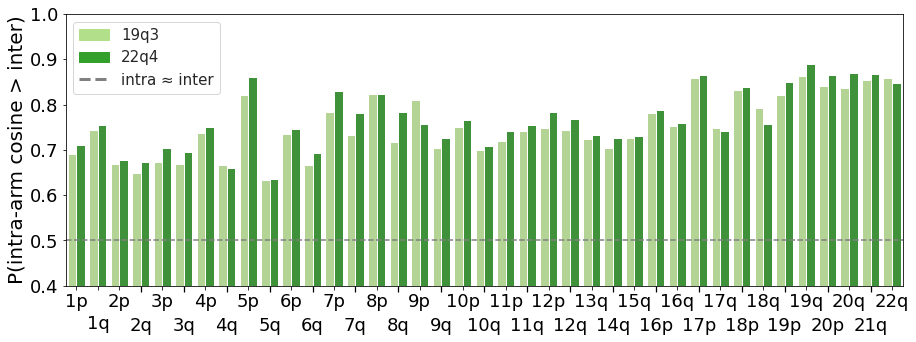

In [124]:
tmp = arm_stats_df
tmp = tmp.reset_index().rename(columns={"prob": "P(intra-arm cosine > inter)"})
tmp = pd.concat([tmp.query('Condition=="19q3"'), tmp.query('Condition=="22q4"')])
plot_bm_bar_pairs(
    tmp,
    x="Chromosome arm",
    y="P(intra-arm cosine > inter)",
    hue="Condition",
    lab1="19q3",
    lab2="22q4",
    i=1,
    legend_loc="upper left",
    f_name=os.path.join(path, "depmap_19q3_vs_22q4_split_bars.svg"),
)

# Make a split heatmap with the 22Q4 and 23Q2 data

Steps:
- Harmonize before pairwise (after cleaning). This drops genes not present in both datasets.
- Make pairwise matrices for each dataset
- Quantile normalize each dataset
- Make split matrix
- Plot

In [30]:
# Harmonize data
depmap3 = {}
intersect_genes = np.intersect1d(
    depmap["22q4"].index.get_level_values("gene"), depmap["23q2"].index.get_level_values("gene")
)
depmap3["22q4"] = depmap["22q4"].query("gene in @intersect_genes")
depmap3["23q2"] = depmap["23q2"].query("gene in @intersect_genes")

In [31]:
# This step can be slow - takes a ~14 minutes on my machine
depmap3_mat = {}
depmap3_mat_norm = {}
for dataset in ["22q4", "23q2"]:
    depmap3_mat[dataset] = make_pairwise_cos(depmap3[dataset])
    depmap3_mat_norm[dataset] = q_norm(depmap3_mat[dataset])

## Plot full genome split heatmap - 22Q4 above diagonal, 23Q2 below

In [32]:
path = "plots"
if not os.path.exists(path):
    os.mkdir(path)

In [33]:
depmap_22q4_23q2_split = make_split_cosmat(depmap3_mat_norm["22q4"], depmap3_mat_norm["23q2"])

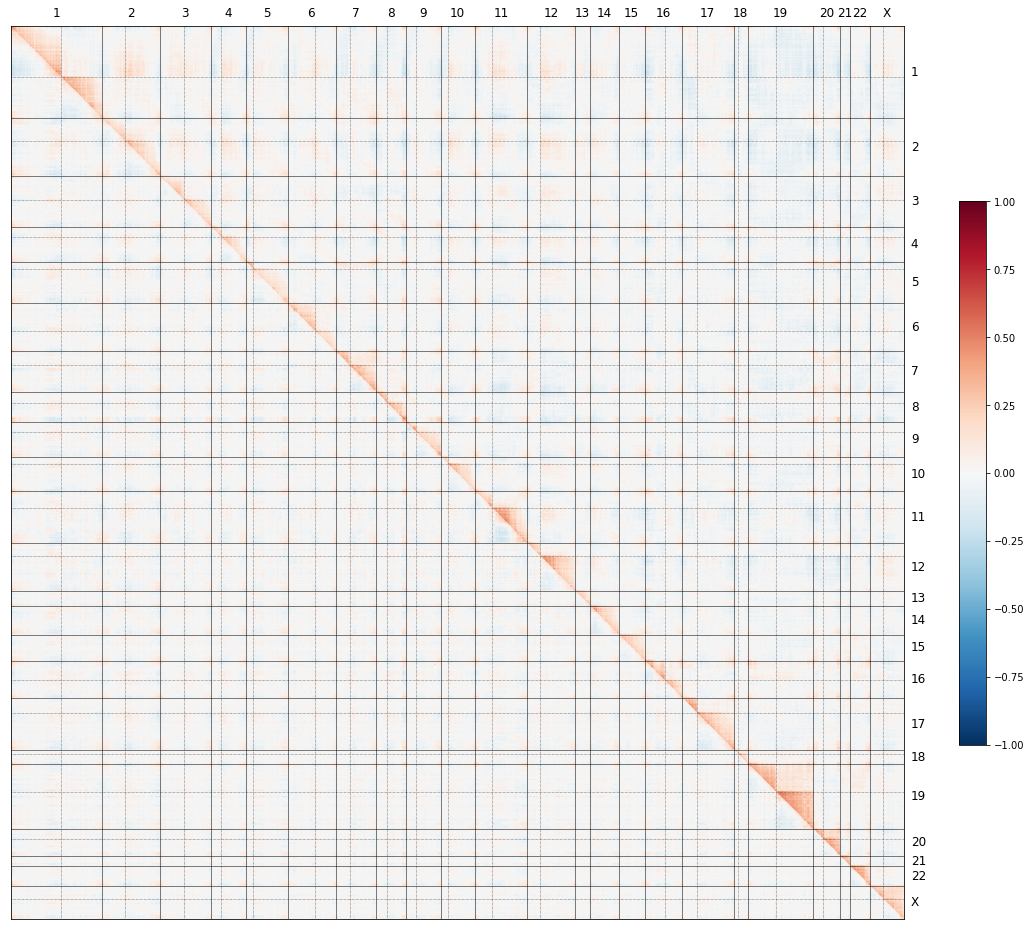

In [34]:
plot_heatmap(
    depmap_22q4_23q2_split,
    f_name=os.path.join(path, "depmap_22q4_vs_23q2_split.svg"),
    format="svg",
    show_chr_lines=True,
    show_cent_lines=True,
    crunch_factor=10,
    title="",
)

## Zoom in on chromosome 1

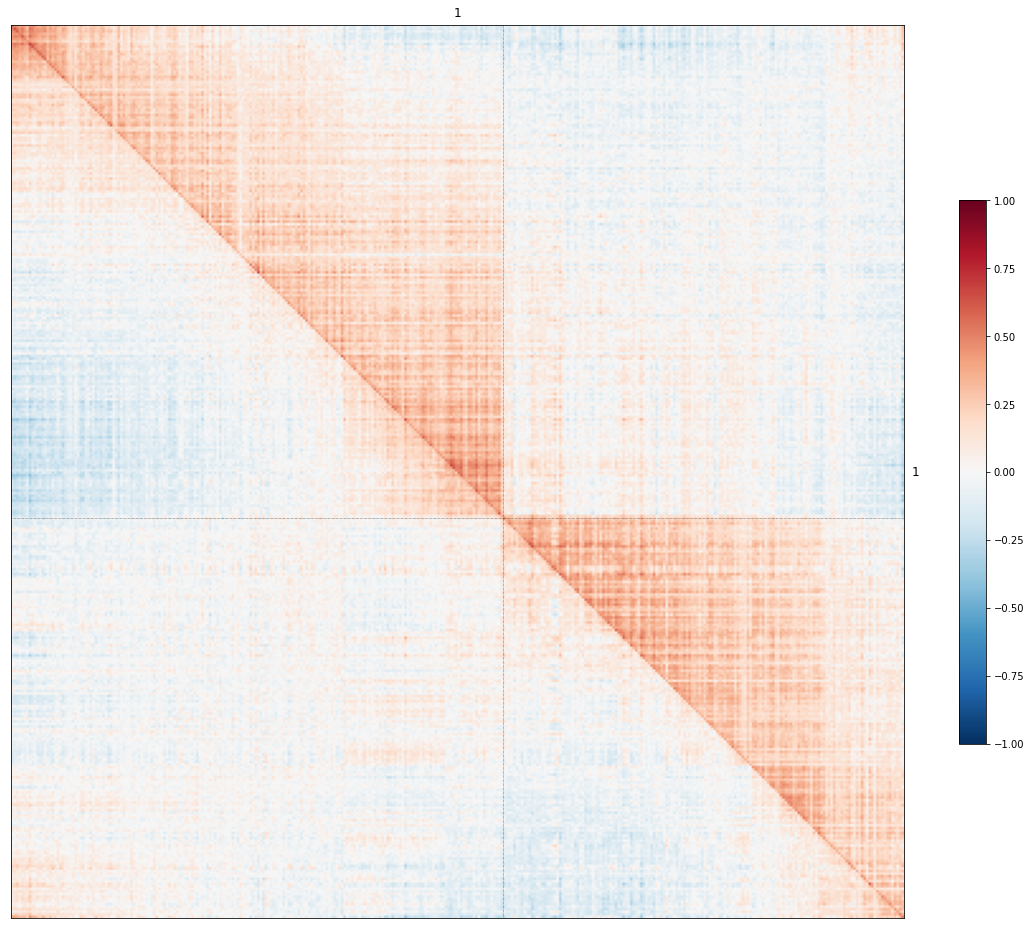

In [35]:
idx = depmap_22q4_23q2_split.query('chromosome=="chr1"').index
plot_heatmap(
    depmap_22q4_23q2_split.loc[idx, idx],
    f_name=os.path.join(path, "depmap_22q4_vs_23q2_split_chr1.svg"),
    format="svg",
    show_chr_lines=True,
    show_cent_lines=True,
    crunch_factor=5,
    title="",
)

## Calculate BM stats

In [36]:
# Setting sample fraction helps avoid memory issues
bm_all3 = {}
bm_arm3 = {}
for dataset in ["22q4", "23q2"]:
    bm_all3[dataset], bm_arm3[dataset] = bm_metrics(depmap3_mat_norm[dataset], verbose=False, sample_frac=0.1)

In [125]:
tmp1 = bm_arm3["22q4"].copy()
tmp1.index.name = "Chromosome arm"
tmp1 = tmp1.assign(Condition="22q4")
tmp1 = tmp1.reset_index().set_index(["Condition", "Chromosome arm"])

tmp2 = bm_arm3["23q2"].copy()
tmp2.index.name = "Chromosome arm"
tmp2 = tmp2.assign(Condition="23q2")
tmp2 = tmp2.reset_index().set_index(["Condition", "Chromosome arm"])

arm_stats_df = pd.concat([tmp1, tmp2])

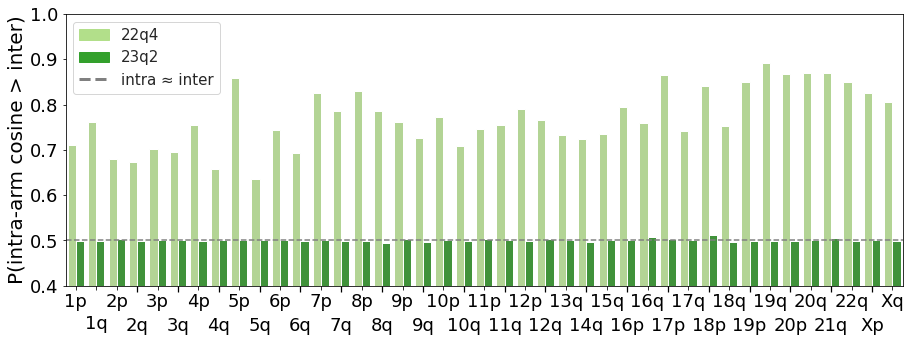

In [126]:
tmp = arm_stats_df
tmp = tmp.reset_index().rename(columns={"prob": "P(intra-arm cosine > inter)"})
tmp = pd.concat([tmp.query('Condition=="22q4"'), tmp.query('Condition=="23q2"')])
plot_bm_bar_pairs(
    tmp,
    x="Chromosome arm",
    y="P(intra-arm cosine > inter)",
    hue="Condition",
    lab1="22q4",
    lab2="23q2",
    i=1,
    legend_loc="upper left",
    f_name=os.path.join(path, "depmap_22q4_vs_23q2_split_bars.svg"),
)